# English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2024/11/18<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir("/content/drive/MyDrive/Diplomado_IA/NLP/Keras Translator")

In [4]:
text_file = "spa.txt"

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [5]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []

for i in range(0, len(lines)):
  eng, spa = lines[i].split("\t")[0], lines[i].split("\t")[1]
  spa = "[start] " + spa + " [end]"
  text_pairs.append((eng, spa))

Here's what our sentence pairs look like:

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('Which branch of the armed forces were you in?', '[start] ¿En qué rama de las fuerzas armadas ha servido usted? [end]')
('Seen from the sky, the river looked like a huge snake.', '[start] Visto desde el cielo, el río se parecía a una enorme serpiente. [end]')
('Tom wants to kill you, Mary.', '[start] Mary, Tom quiere matarte. [end]')
("I'll show you how it's done.", '[start] Te mostraré cómo se hace. [end]')
("Someone like you won't be able to do that.", '[start] Alguien como tú no sería capaz de hacer eso. [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [7]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

141543 total pairs
99081 training pairs
21231 validation pairs
21231 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [9]:
len(eng_vectorization.get_vocabulary())

12925

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `decoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [10]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [11]:
list(train_ds)

[({'encoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
   array([[    2,    18,   224, ...,     0,     0,     0],
          [   17,  2390,     8, ...,     0,     0,     0],
          [    2,    58,     2, ...,     0,     0,     0],
          ...,
          [  145,    68, 12763, ...,     0,     0,     0],
          [  145,    34,    35, ...,     0,     0,     0],
          [   20,   161,    74, ...,     0,     0,     0]])>,
   'decoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
   array([[    2,    68,   460, ...,     0,     0,     0],
          [    2,    42,  1867, ...,     0,     0,     0],
          [    2,    83,     5, ...,     0,     0,     0],
          ...,
          [    2,    11,    13, ...,     0,     0,     0],
          [    2,    27,     6, ...,     0,     0,     0],
          [    2,     6, 12083, ...,     0,     0,     0]])>},
  <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
  array([[   68,   460,    23, ...,     0,     0,     0],
         

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [12]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [13]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


Next, we assemble the end-to-end model.

In [14]:
sequence_length

20

In [15]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [16]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 256)      │      3,845,120 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 256)      │      3,845,120 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 256)      │      3,155,456 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ (None, None, 256)      │      5,259,520 │ positional_embedding_… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder[0… │
│                           │                        │                │ not_equal_1[0][0],     │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 256)      │              0 │ transformer_decoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, None, 15000)    │      3,855,000 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 92s 34ms/step - accuracy: 0.1083 - loss: 4.9280 - val_accuracy: 0.1932 - val_loss: 2.8286
Epoch 2/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1961 - loss: 2.8290 - val_accuracy: 0.2138 - val_loss: 2.4148
Epoch 3/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2140 - loss: 2.4558 - val_accuracy: 0.2197 - val_loss: 2.3022
Epoch 4/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2234 - loss: 2.2731 - val_accuracy: 0.2255 - val_loss: 2.2274
Epoch 5/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2293 - loss: 2.1733 - val_accuracy: 0.2270 - val_loss: 2.2310
Epoch 6/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2340 - loss: 2.1107 - val_accuracy: 0.2288 - val_loss: 2.2377
Epoch 7/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2376 - loss: 2.0580 - val_accuracy: 0.2306 - val_loss: 2.2137
Epoch 8/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2400 -

In [17]:
transformer.save("zoe_simple_model_30_epochs.keras")

<ipython-input-19-5bb2403c0f43>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
<ipython-input-19-5bb2403c0f43>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


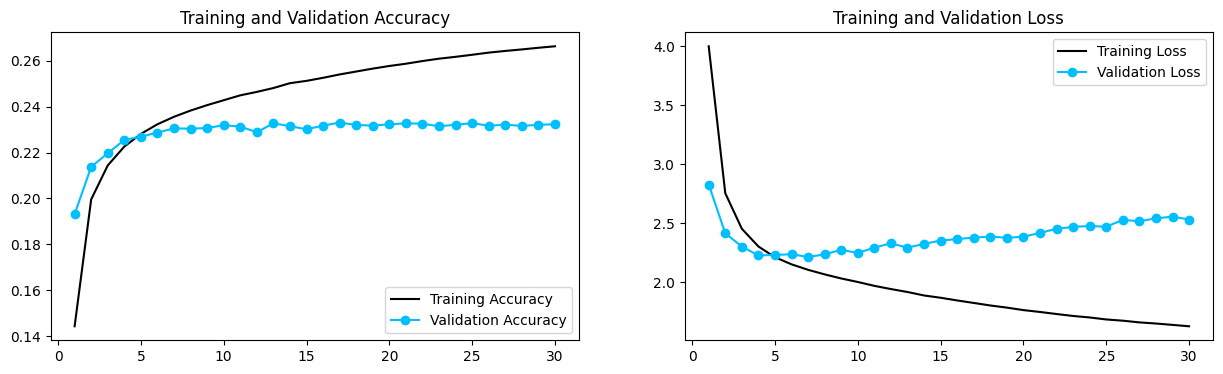

In [19]:
import matplotlib.pyplot as plt

# Plot Training History (Optional but very useful)
acc = transformer.history.history['accuracy']
val_acc = transformer.history.history['val_accuracy']

loss = transformer.history.history['loss']
val_loss = transformer.history.history['val_loss']

epochs_range = range(1, 30+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_AlexNet.jpg')

plt.show()

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [20]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    print(input_sentence, "---> ", translated)

You are the only one who can protect them. --->  [start] eres el único que puede abrir el que puede que los [UNK] [end]
You know this. --->  [start] tú sabes esto [end]
The dog went away. --->  [start] el perro se salió [end]
Tom's part-time job is delivering pizzas. --->  [start] el trabajo de tom es con [UNK] los [UNK] [end]
This is driving me crazy. --->  [start] esto me está manejando loco [end]
May I help you? --->  [start] puedo ayudarte [end]
You can't please everyone. --->  [start] no puedes [UNK] por favor [end]
Turn off the gas. --->  [start] enciende la gasolina [end]
They congratulated us on our victory. --->  [start] ellos me compraron por nuestra victoria la mía [end]
I have a lot of homework. --->  [start] tengo muchos deberes [end]
Work hard, or you'll have to take the same course again next year. --->  [start] o sí que tienes que tomar el mismo momento por favor [end]
Mary decorated the cake. --->  [start] mary [UNK] la tarta [end]
He's been confined to bed for the pas